# Clean data

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

## Prepare raw data(responses)/key(dimension)/relationships

In [3]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = [i for i in os.listdir('input_data/') if i.startswith('CHN_group')][1]

# Prep responses and key
raw = pd.read_csv(os.getcwd()+'/input_data/'+qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])

# Prep responses and key
key = pd.read_csv('input_data/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

Total number of responses from qualtrics - 69


In [4]:
# Prep relationships
filter_col = [col for col in raw if col.startswith('Q4.2')]
relationships = pd.read_csv('input_data/group_relationships_fix_label.csv', index_col=0)
relationships = relationships.iloc[:,0].to_list()

# Prep dimensions
dimensions = key['dimension'].tolist()[1:-1]
items_to_remove = ["foil", "foil size"]

dimensions = [item for item in dimensions if item not in items_to_remove]

dimension_frames = {}
count = 1
for dim in dimensions:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q' + str(key['block'].iloc[count]) + '.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    
    count += 1
# Get total number of relationships and dimensions      
print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))

Total number of relationships - 25
Total number of dimensions - 33


## time/foil/foil_size

In [5]:
time = pd.to_numeric(raw_reorg['Duration (in seconds)'], errors='coerce')
time[time > time.mean() + 3.5 * time.std()]
outliers_max = time.index[time == time.max()]
time = time[~time.index.isin(outliers_max)]
outliers = time[time < time.mean() - 1.5 * time.std()]
outliers

62    37
65    19
66    23
67    13
Name: Duration (in seconds), dtype: int64

In [6]:
time = pd.to_numeric(raw_reorg['Duration (in seconds)'], errors='coerce')
print(time.max())
time_max_index = time.index[time == time.max()]
time = time[~time.index.isin(time_max_index)]
time = pd.DataFrame(time)

time['Random ID'] =raw_reorg['Random ID']
time = time.apply(pd.to_numeric)
time_melt = pd.melt(time, id_vars='Random ID')

outliers_time_list = list(time_max_index)
for col in time.columns[:-1]:
    outliers_time_list = outliers_time_list + list(time[time[col] < time[col].mean()-time[col].std()*1.5].index)
outliers_time_list = set(outliers_time_list)

outliers_time_list

11007


{62, 65, 66, 67, 68}

In [7]:
# Check foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q38.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [i.split(' - ', 1)[1] if ' - ' in i else i for i in foil_items]

filtered_cols = [col for col in raw_reorg if col.startswith('Q38.1')]
foils_size = pd.DataFrame(responses[filtered_cols])
foils_size.columns = foil_items
foils_size['Random ID'] =raw_reorg['Random ID']
foils_size = foils_size.apply(pd.to_numeric)

foils_size_melt = pd.melt(foils_size, id_vars='Random ID')

In [8]:
# Check for values above means for unexpected foils
outliers_size_list = []
for col in foils_size.columns[:-1]:
    outliers_size_list = outliers_size_list + list(foils_size[(foils_size[col] > foils_size[col].mean()+foils_size[col].std()*3.5) |
                   (foils_size[col] < foils_size[col].mean()-foils_size[col].std()*3.5)].index)
outliers_size_list = set(outliers_size_list)

In [9]:
# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_size_outliers = foils_size
foil_size_outliers = foil_size_outliers[~foil_size_outliers.index.isin(outliers_size_list)]
foil_size_outliers_melt = pd.melt(foil_size_outliers, id_vars='Random ID')
foil_size_outliers_melt.columns = ['Random ID','variable','value']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


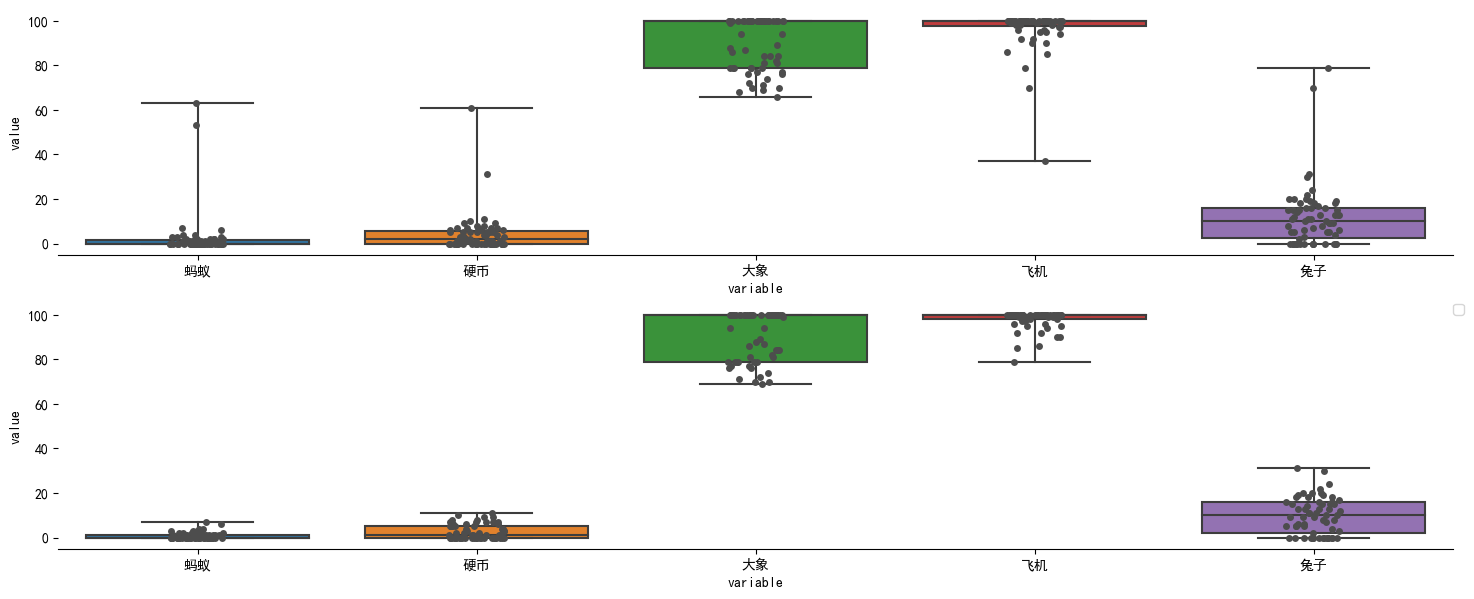

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei']
f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
sns.stripplot(x="variable", y="value", data=foils_size_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_size_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_size_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_size_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

In [11]:
# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q37')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q37.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_items = [i.split(' - ', 1)[1] for i in foil_items if ' - ' in i]
filtered_cols = [col for col in raw_reorg if col.startswith('Q37.1')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['Random ID']  =raw_reorg['Random ID']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='Random ID')

In [12]:
# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > foils[rel].mean()+foils[rel].std()*3.5) |
                   (foils[rel] < foils[rel].mean()-foils[rel].std()*3.5)].index)
outliers_list = set(outliers_list)

In [13]:
# Remove outliers based on assumptions of words
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='Random ID')
foil_outliers_melt.columns = ['Random ID','variable','value']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


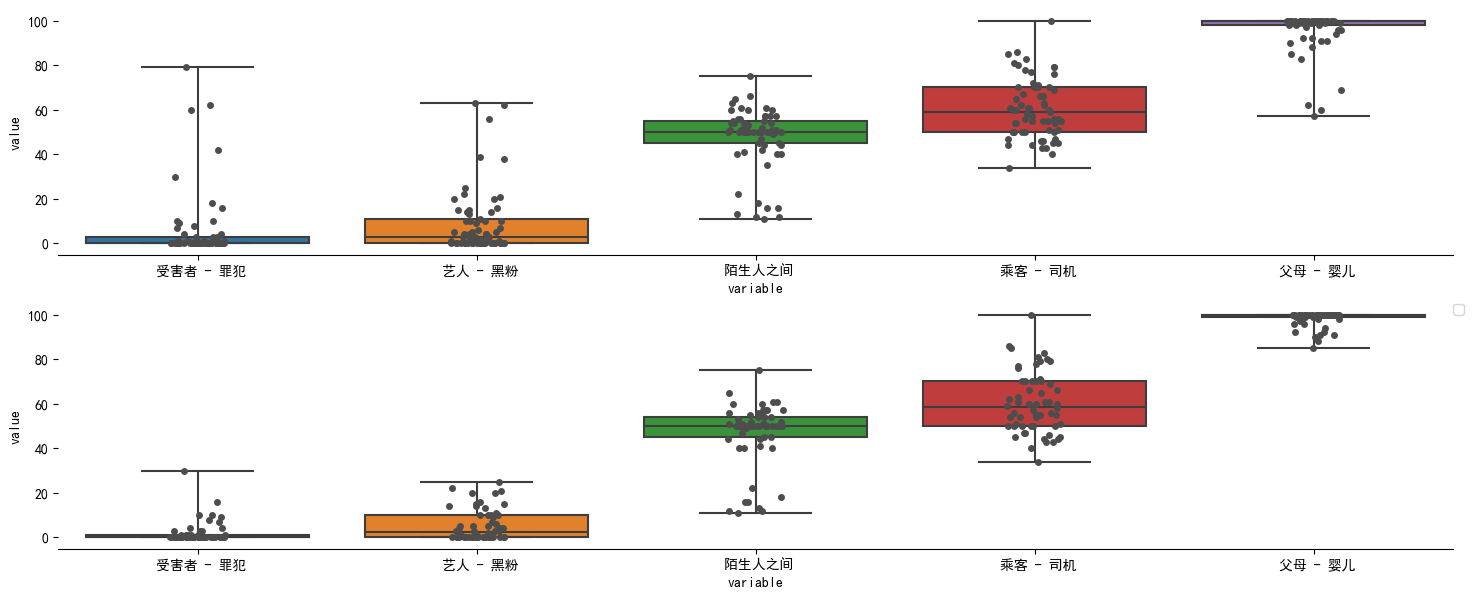

In [14]:
f, axes = plt.subplots(2, 1, figsize=(18, 7), sharex=False)
sns.despine(left=True)
foils_melt['variable'] = [i.split('程度 -')[1] for i in foils_melt['variable']]
foil_outliers_melt['variable'] = [i.split('程度 -')[1] for i in foil_outliers_melt['variable']]
sns.stripplot(x="variable", y="value", data=foils_melt, 
              color='.3', jitter=True, ax=axes[0])
sns.stripplot(x="variable", y="value", data=foil_outliers_melt, 
              color='.3', jitter=True,  ax=axes[1])
sns.boxplot(x="variable", y="value", data=foils_melt, whis=np.inf, ax=axes[0])
sns.boxplot(x="variable", y="value", data=foil_outliers_melt, whis=np.inf, ax=axes[1])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.0)

In [15]:
# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['Random ID'] = raw_reorg['Random ID']
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='Random ID')

In [16]:
# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

In [17]:
# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_size_list) + list(familiarity_list)+list(outliers_time_list))
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    temp_df = dimension_frames_outliers[dim].count()
    temp_df.index = relationships
    num_response_outliers[dim] = temp_df

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

Total number of responses, excluding bad participants - 59
Smallest number of ratings for a relationship - 9
Largest number of ratings for a relationship - 14


In [19]:
result_dict = dimension_frames_outliers
with pd.ExcelWriter('output_data/dict_results/CHN_group.xlsx')as writer:
    for dim in result_dict.keys():
        temp_df = result_dict[dim]
        temp_df.columns = relationships
        temp_df.to_excel(writer, sheet_name = dim)

## Demographics

In [20]:
filtered_demo = [col for col in raw_reorg if col.startswith('Q39')]
response_demographic = raw_reorg.loc[:,filtered_demo]
response_demographic = response_demographic[~response_demographic.index.isin(outliers_all_list)]
response_demographic.columns = ['Age','Gender','Race','Ethnicity',
                                'Highest education','First language','First language alternative']
response_demographic.head()

,Age,Gender,Race,Ethnicity,Highest education,First language,First language alternative
0,18 - 24,男,汉族,NaN,硕士,是,NaN
2,18 - 24,男,汉族,NaN,大学本科,是,NaN
5,18 - 24,男,汉族,NaN,大学本科,是,NaN
6,25 - 34,男,汉族,NaN,大学本科,是,NaN
7,18 - 24,女,汉族,NaN,大学本科,是,NaN


### Gender

In [21]:
response_demographic['Gender'][response_demographic['Gender'].isna()] = 'No response'
response_demographic['Gender'].value_counts()

女              30
男              28
No response     1
Name: Gender, dtype: int64

### Age

In [22]:
response_demographic['Age'][response_demographic['Age'].isna()] = 'No response'
response_demographic['Age'].value_counts()

18 - 24        37
25 - 34        19
35 - 44         2
No response     1
Name: Age, dtype: int64

### Race

In [23]:
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'].value_counts()

汉族             58
No response     1
Name: Race, dtype: int64

### Highest education

In [24]:
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'].value_counts()

大学本科           45
硕士             12
大专              1
No response     1
Name: Highest education, dtype: int64

### First language

In [25]:
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'].value_counts()

是              58
No response     1
Name: First language, dtype: int64

## Heatmap

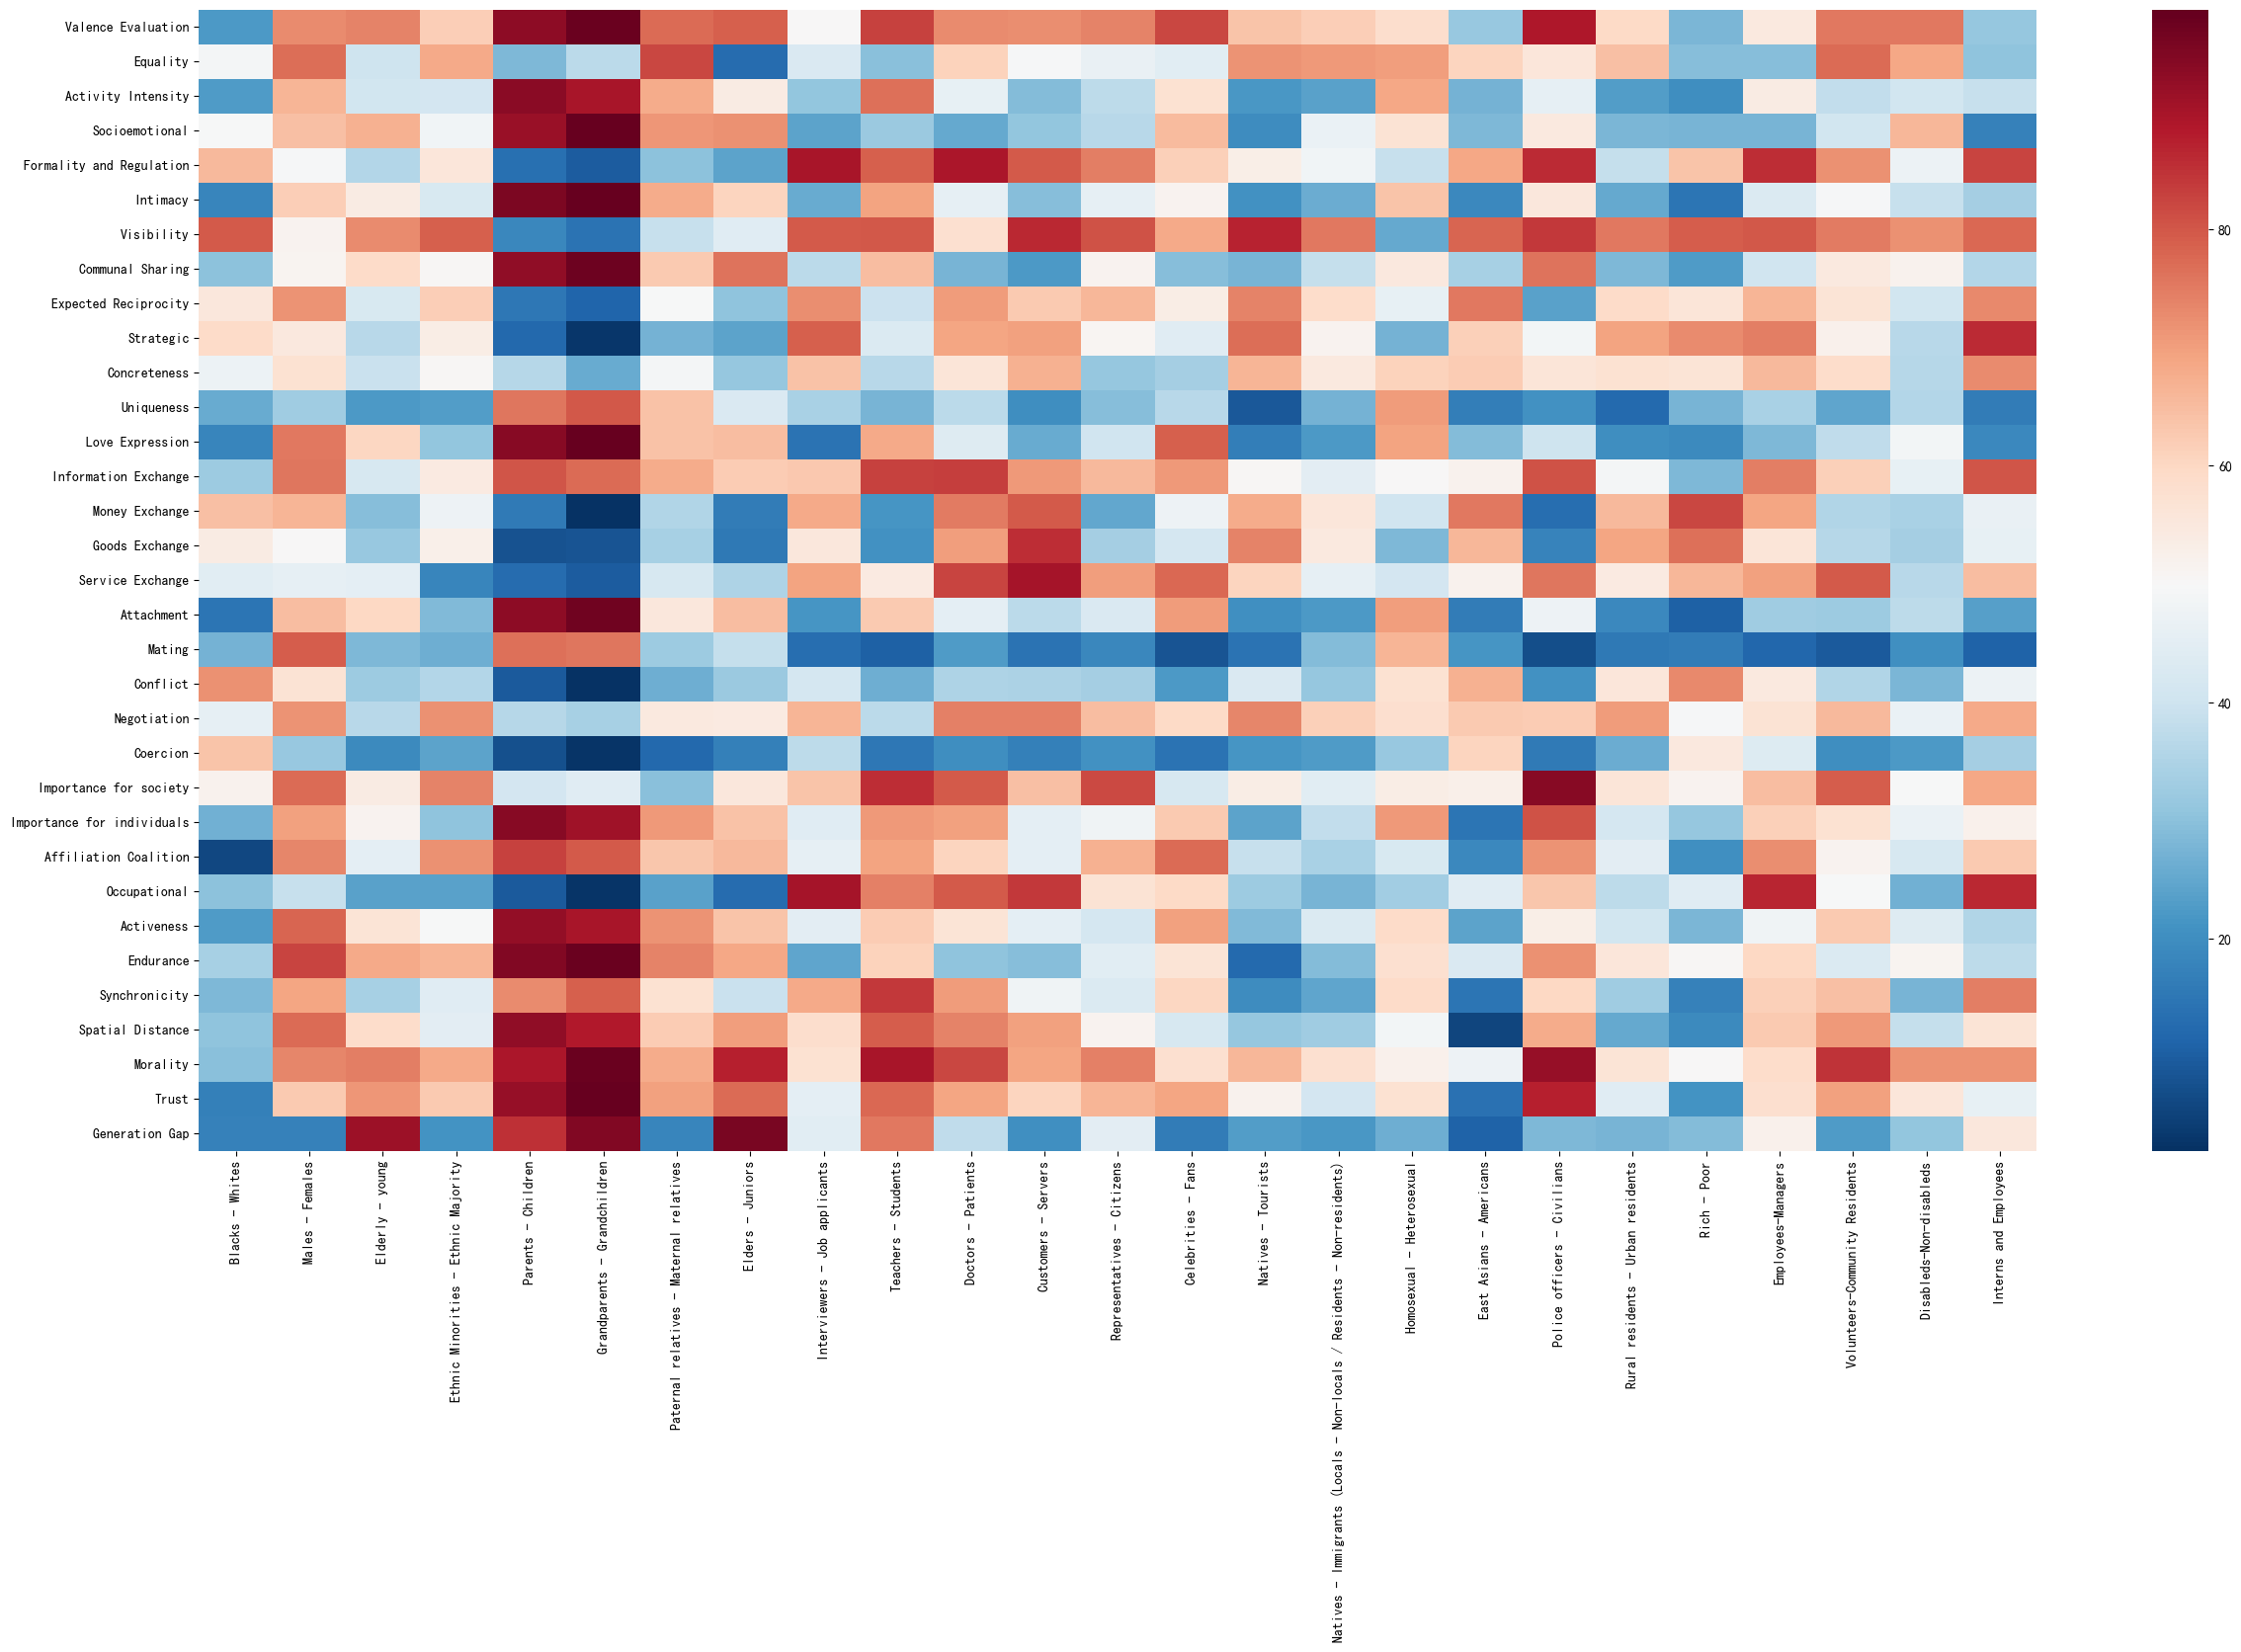

In [26]:
dim_rel = pd.DataFrame(columns = relationships)
count=0
for dim in dimensions:
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimensions
dim_rel.to_csv('output_data/cleaning_results/chn_group_dim_rel_33d.csv')

plt.figure(figsize=(30,15))
sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,index=dim_rel.columns,columns=dim_rel.index)
dim_rel_scaled.to_csv('output_data/cleaning_results/chn_group_dim_rel_scaled_33d.csv')